In [1]:
%matplotlib widget

In [2]:
# Plot error space for one example of case A.2

# Import libraries
import numpy as np
import pygimli as pg
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from sklearn.metrics import root_mean_squared_error
import sys
sys.path.insert(1, '../../src')

# Import functions
from EM1D import EMf_2Lay_HVP_Q, GlobalSearch_2Lay, EMf_2Lay_Opt_HVP_Q_1D

In [3]:
# Load model and data
model_A2_1 = np.load('models/model_synth_2Lay_A2_1.npy')
model_A2_2 = np.load('models/model_synth_2Lay_A2_2.npy')
model_A2_3 = np.load('models/model_synth_2Lay_A2_3.npy')
model_A2_4 = np.load('models/model_synth_2Lay_A2_4.npy')

data_A2_1 = np.load('data/data_synth_2Lay_A2_1.npy')
data_A2_2 = np.load('data/data_synth_2Lay_A2_2.npy')
data_A2_3 = np.load('data/data_synth_2Lay_A2_3.npy')
data_A2_4 = np.load('data/data_synth_2Lay_A2_4.npy')

data_A2_1_GS = np.load('data/data_GS_A2_1.npy')

LUT = np.load('../data/LUTable_2Lay.npy')
conds = np.load('../data/conds.npy')
thicks = np.load('../data/thicks.npy')

# Load survey parameters
survey = np.load('../data/survey_2Lay.npy', allow_pickle=True).item()
offsets = survey['offsets']
height = survey['height']
freq = survey['freq']
lambd = survey['lambd']
filt = survey['filt']

# Load estimated model from Global Search
model_GS_A2_1 = np.load('results/model_2Lay_Q_A2_1.npy')
model_GS_A2_2 = np.load('results/model_2Lay_Q_A2_2.npy')
model_GS_A2_3 = np.load('results/model_2Lay_Q_A2_3.npy')
model_GS_A2_4 = np.load('results/model_2Lay_Q_A2_4.npy')

# Load estimated models from Optimization
model_GI_A2_1 = np.load('results/model_Opt_Q_A2_1.npy')
model_GI_A2_2 = np.load('results/model_Opt_Q_A2_2.npy')
model_GI_A2_3 = np.load('results/model_Opt_Q_A2_3.npy')
model_GI_A2_4 = np.load('results/model_Opt_Q_A2_4.npy')

# For example let's check the 1D model following position
pos = 10
nsl = len(conds)

model_ini = np.array([3,500/1000,500/1000])

In [4]:
model_GI_A2_1_hist = np.load('results/model_Opt_A2_1_hist_Q.npy')
model_GI_A2_2_hist = np.load('results/model_Opt_A2_2_hist_Q.npy')
model_GI_A2_3_hist = np.load('results/model_Opt_A2_3_hist_Q.npy')
model_GI_A2_4_hist = np.load('results/model_Opt_A2_4_hist_Q.npy')

In [5]:
def nrmse(obs, pred):
    
    nrse = root_mean_squared_error(obs, pred)/np.abs(np.max(obs)-np.min(obs))
    return nrse

In [6]:

def Error_analysis_sigma1(model_true, data_true, pos, thicks, conds):
    """ change later rmse"""
    err = []
    models_err = []
    for h1 in thicks:
        for sigma2 in conds:
            mod = [h1, model_true[pos,1], sigma2]
            sigma1 = model_true[pos,1]
            dat = EMf_2Lay_HVP_Q(lambd, sigma1, sigma2, h1, height, offsets, freq, filt)
            nrse = nrmse(data_true[pos,:9], dat)
            
            if nrse < .5:
                err.append(nrse)    
                models_err.append(mod)

    err = np.array(err)
    models_err = np.array(models_err)

    return err, models_err

def Error_analysis(model_true, data_true, pos, thicks, conds):
    """ change later rmse"""
    err = []
    models_err = []
    for h1 in thicks:
        for sigma1 in conds:
            for sigma2 in conds:
                mod = [h1, sigma1, sigma2]
                #sigma1 = model_true[pos,1]
                dat = EMf_2Lay_HVP_Q(lambd, sigma1, sigma2, h1, height, offsets, freq, filt)
                nrse = nrmse(data_true[pos,:9], dat)
                
                if nrse < .5:
                    err.append(nrse)    
                    models_err.append(mod)

    err = np.array(err)
    models_err = np.array(models_err)

    return err, models_err
        

In [7]:
err_A2_1_s1, models_err_A2_1_s1 = Error_analysis_sigma1(model_A2_1, data_A2_1, pos, thicks, conds)
err_A2_2_s1, models_err_A2_2_s1 = Error_analysis_sigma1(model_A2_2, data_A2_2, pos, thicks, conds)
err_A2_3_s1, models_err_A2_3_s1 = Error_analysis_sigma1(model_A2_3, data_A2_3, pos, thicks, conds)
err_A2_4_s1, models_err_A2_4_s1 = Error_analysis_sigma1(model_A2_4, data_A2_4, pos, thicks, conds)

In [12]:
# Function to plot Error space

def PlotErrorSpace1(ax1, ax2, model, model_GS, model_GI, model_ini, model_hist, err, models_err, xmin, xmax, ymin, ymax, case='', method='', depthmax=-8, colorbar=False):
    # Arrays to plot
    depth_true = np.array([0, -model[0], depthmax])
    depth_GS = np.array([0, -model_GS[0], depthmax])
    depth_GI = np.array([0, -model_GI[0], depthmax])
    depth_ini = np.array([0, -model_ini[0], depthmax])

    sigma_true = np.hstack([model[1:], model[-1]])
    sigma_GS = np.hstack([model_GS[1:], model_GS[-1]])
    sigma_GI = np.hstack([model_GI[1:], model_GI[-1]])
    sigma_ini = np.hstack([model_ini[1:], model_ini[-1]])
       
  #  fig, ax = plt.subplots(1,2, figsize=(6,4), gridspec_kw={'width_ratios': [1,1.5]})
    
    ax1.step(sigma_true*1000, depth_true, 'k', label = 'True', linewidth=4)
    ax1.step(sigma_GS*1000, depth_GS, 'r', label='GS')
    ax1.step(sigma_GI*1000, depth_GI, 'c', label='GI')
    ax1.step(sigma_ini*1000, depth_ini, 'g', label='Initial')
    ax1.set_xlim([9,2100])
    ax1.set_ylabel('Depth [m]', fontsize=8)
    ax1.set_xlabel('$\sigma$ [mS/m]', fontsize=8)
    ax1.set_title('1D Model X=' +str(pos) + 'm - '+case, fontsize=8)
    ax1.set_xscale('log')
    ax1.legend(fontsize=7)

    x = ((models_err[:,2])*1000) # conductivities of first layer in mS/m
    y = models_err[:,0]          # thickness of first layer
    z = err

    ngridx = 100
    ngridy = 200
    
    # Create grid values first.
    xi = np.linspace(np.min(x), np.max(x), ngridx)
    yi = np.linspace(np.min(y), np.max(y), ngridy)

    # Linearly interpolate the data (x, y) on a grid defined by (xi, yi).
    triang = tri.Triangulation(x, y)
    interpolator = tri.LinearTriInterpolator(triang, z)
    Xi, Yi = np.meshgrid(xi, yi)
    zi = interpolator(Xi, Yi)

    ax2.contour(xi, yi, zi*100, levels=15, linewidths=0.5, colors='k', )
    cntr1 = ax2.contourf(xi, yi, zi*100, levels=15, cmap="RdBu_r", vmin=0,vmax=50)
    #ax2.plot(x, y, '.k', ms=1)
    ax2.set(xlim=(xmin, xmax), ylim=(ymin, ymax))
    ax2.scatter(model[2]*1000, model[0], marker='o', c='w', label='True model', s=100)
    ax2.scatter(((model_GS[2])*1000), model_GS[0], marker ='x', c='r', label='GS', s=100)
    ax2.scatter(((model_GI[2])*1000), model_GI[0], marker ='.', c='y', label='GN', s=100)  
    ax2.scatter(((model_ini[2])*1000), model_ini[0], marker ='.', c='k', label='Initial', s=100)  
    for i in range(len(model_hist)+1):
        x = model_hist[i-1:i+1,2]*1000
        y = model_hist[i-1:i+1,0]
        ax2.plot(x,y, ':k')
    ax2.set_xlabel('$\sigma_2$ [mS/m]', fontsize=8)
    ax2.set_ylabel('$h_1$ [m]', fontsize=8)
    ax2.legend(fontsize=7, loc='lower right')
    ax2.tick_params(axis='both',labelsize=9)
    #ax1.tick_params(axis='both',labelsize=9)
    ax2.set_title(method, fontsize=8)
    ax2.set_xscale('log')
    
    if colorbar==True:
        clb = fig.colorbar(cntr1, ax=ax2, ticks=[0,10,20,30,40,50])
        clb.ax.set_title('NRMSE %', fontsize=7)
        clb.ax.tick_params(labelsize=9)

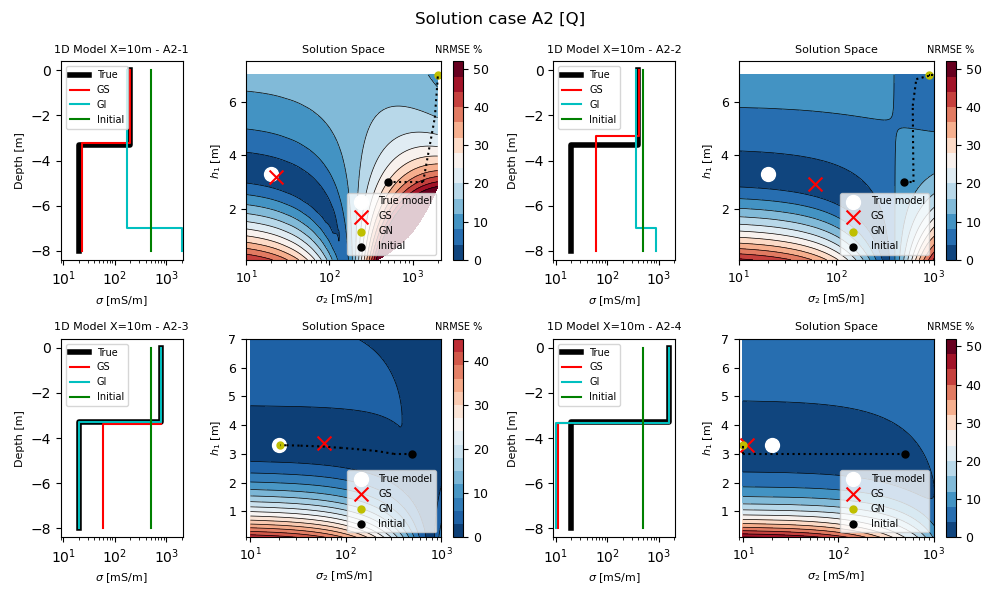

In [13]:
fig, ax = plt.subplots(2,4, figsize=(10,6), gridspec_kw={'width_ratios': [1, 2, 1, 2]})

PlotErrorSpace1(ax1=ax[0,0], ax2=ax[0,1], model=model_A2_1[pos], model_GS=model_GS_A2_1[pos], model_GI=model_GI_A2_1[pos],
               model_ini=model_ini,model_hist= model_GI_A2_1_hist, err=err_A2_1_s1, models_err=models_err_A2_1_s1, 
               xmin=np.min(conds)*1000, xmax=2200, ymin=np.min(thicks), ymax=np.max(thicks)+.5, case='A2-1',method= 'Solution Space',colorbar= True)
PlotErrorSpace1(ax[0,2], ax[0,3], model_A2_2[pos], model_GS_A2_2[pos], model_GI_A2_2[pos], model_ini, model_GI_A2_2_hist, 
                err_A2_2_s1, models_err_A2_2_s1,
               np.min(conds)*1000, 1000, np.min(thicks), np.max(thicks)+.5,
              case='A2-2', method='Solution Space', colorbar=True)
PlotErrorSpace1(ax[1,0], ax[1,1], model_A2_3[pos], model_GS_A2_3[pos], model_GI_A2_3[pos], model_ini, model_GI_A2_3_hist,
                err_A2_3_s1, models_err_A2_3_s1, 9, 1000, 
               np.min(thicks), np.max(thicks),
              case='A2-3', method='Solution Space', colorbar=True)
PlotErrorSpace1(ax[1,2], ax[1,3], model_A2_4[pos], model_GS_A2_4[pos], model_GI_A2_4[pos], model_ini, model_GI_A2_4_hist, 
                err_A2_4_s1, models_err_A2_4_s1, 9, 1000, 
               np.min(thicks), np.max(thicks),
              case='A2-4', method='Solution Space', colorbar=True)
fig.suptitle('Solution case A2 [Q]')
plt.tight_layout()
#plt.show()
#plt.savefig('figures/ErrorSpace_caseA2.eps', format='eps')

In [14]:

def Error_analysis_sigma2(model_true, data_true, pos, thicks, conds):
    """ change later rmse"""
    err = []
    models_err = []
    for h1 in thicks:
        for sigma1 in conds:
            mod = [h1, sigma1, model_true[pos,2]]
            sigma2 = model_true[pos,2]
            dat = EMf_2Lay_HVP_Q(lambd, sigma1, sigma2, h1, height, offsets, freq, filt)
            nrse = nrmse(data_true[pos,:9], dat)
            
            if nrse < .5:
                err.append(nrse)    
                models_err.append(mod)

    err = np.array(err)
    models_err = np.array(models_err)

    return err, models_err

In [15]:
err_A2_1_s2, models_err_A2_1_s2 = Error_analysis_sigma2(model_A2_1, data_A2_1, pos, thicks, conds)
err_A2_2_s2, models_err_A2_2_s2 = Error_analysis_sigma2(model_A2_2, data_A2_2, pos, thicks, conds)
err_A2_3_s2, models_err_A2_3_s2 = Error_analysis_sigma2(model_A2_3, data_A2_3, pos, thicks, conds)
err_A2_4_s2, models_err_A2_4_s2 = Error_analysis_sigma2(model_A2_4, data_A2_4, pos, thicks, conds)

In [17]:
# Function to plot Error space

def PlotErrorSpace2(ax1, ax2, model, model_GS, model_GI, model_ini, model_hist, err, models_err, xmin, xmax, ymin, ymax, case='', method='', depthmax=-8, colorbar=False):
    # Arrays to plot
    depth_true = np.array([0, -model[0], depthmax])
    depth_GS = np.array([0, -model_GS[0], depthmax])
    depth_GI = np.array([0, -model_GI[0], depthmax])
    depth_ini = np.array([0, -model_ini[0], depthmax])

    sigma_true = np.hstack([model[1:], model[-1]])
    sigma_GS = np.hstack([model_GS[1:], model_GS[-1]])
    sigma_GI = np.hstack([model_GI[1:], model_GI[-1]])
    sigma_ini = np.hstack([model_ini[1:], model_ini[-1]])
       
  #  fig, ax = plt.subplots(1,2, figsize=(6,4), gridspec_kw={'width_ratios': [1,1.5]})
    
    ax1.step(sigma_true*1000, depth_true, 'k', label = 'True', linewidth=4)
    ax1.step(sigma_GS*1000, depth_GS, 'r', label='GS')
    ax1.step(sigma_GI*1000, depth_GI, 'c', label='GN')
    ax1.step(sigma_ini*1000, depth_ini, 'g', label='Initial')
    ax1.set_xlim([9,2100])
    ax1.set_ylabel('Depth [m]', fontsize=8)
    ax1.set_xlabel('$\sigma$ [mS/m]', fontsize=8)
    ax1.set_title('1D Model X= ' +str(pos) + 'm - Case: '+case, fontsize=8)
    ax1.set_xscale('log')
    ax1.legend(fontsize=7)

    x = ((models_err[:,1])*1000) # conductivities of first layer in mS/m
    y = models_err[:,0]          # thickness of first layer
    z = err

    ngridx = 100
    ngridy = 200
    
    # Create grid values first.
    xi = np.linspace(np.min(x), np.max(x), ngridx)
    yi = np.linspace(np.min(y), np.max(y), ngridy)

    # Linearly interpolate the data (x, y) on a grid defined by (xi, yi).
    triang = tri.Triangulation(x, y)
    interpolator = tri.LinearTriInterpolator(triang, z)
    Xi, Yi = np.meshgrid(xi, yi)
    zi = interpolator(Xi, Yi)

    ax2.contour(xi, yi, zi*100, levels=15, linewidths=0.5, colors='k', )
    cntr1 = ax2.contourf(xi, yi, zi*100, levels=15, cmap="RdBu_r", vmin=0, vmax=50)
    #ax2.plot(x, y, '.k', ms=1)
    ax2.set(xlim=(xmin, xmax), ylim=(ymin, ymax))
    ax2.scatter(model[1]*1000, model[0], marker='o', c='w', label='True model', s=100)
    ax2.scatter(((model_GS[1])*1000), model_GS[0], marker ='x', c='r', label='GS', s=100)
    ax2.scatter(((model_GI[1])*1000), model_GI[0], marker ='.', c='y', label='GN', s=100)  
    ax2.scatter(((model_ini[1])*1000), model_ini[0], marker ='.', c='k', label='Ini', s=100) 
    for i in range(len(model_hist)+1):
        x = model_hist[i-1:i+1,1]*1000
        y = model_hist[i-1:i+1,0]
        ax2.plot(x,y, ':k')
    ax2.set_xlabel('$\sigma_1$ [mS/m]', fontsize=8)
    ax2.set_ylabel('$h_1$ [m]', fontsize=8)
    ax2.legend(fontsize=7)
    ax2.tick_params(axis='both',labelsize=9)
    ax1.tick_params(axis='both',labelsize=9)
    ax2.set_title(method, fontsize=8)
    ax2.set_xscale('log')
    
    if colorbar==True:
        clb = fig.colorbar(cntr1, ax=ax2, ticks=[0,10,20,30,40,50])
        clb.ax.set_title('NRMSE %', fontsize=7)
        clb.ax.tick_params(labelsize=9)

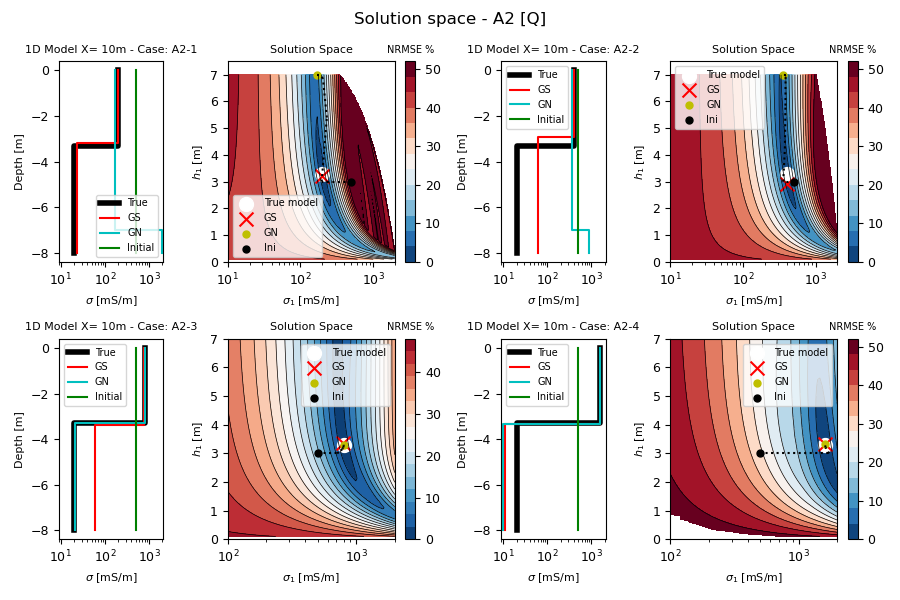

In [21]:
fig, ax = plt.subplots(2,4, figsize=(9,6), gridspec_kw={'width_ratios': [1, 2, 1, 2]})

PlotErrorSpace2(ax[0,0], ax[0,1], model_A2_1[pos], model_GS_A2_1[pos], model_GI_A2_1[pos], model_ini, model_GI_A2_1_hist,
               err_A2_1_s2, models_err_A2_1_s2, 10, 2000, 0, 7.5, 
               case='A2-1', method='Solution Space', colorbar=True)
PlotErrorSpace2(ax[0,2], ax[0,3], model_A2_2[pos], model_GS_A2_2[pos], model_GI_A2_2[pos], model_ini, model_GI_A2_2_hist, 
               err_A2_2_s2, models_err_A2_2_s2, 10, 2000,  0, 7.5,
              case='A2-2', method='Solution Space', colorbar=True)
PlotErrorSpace2(ax[1,0], ax[1,1], model_A2_3[pos], model_GS_A2_3[pos], model_GI_A2_3[pos], model_ini, model_GI_A2_3_hist,
               err_A2_3_s2, models_err_A2_3_s2, 100, 2000,  0, 7,
              case='A2-3', method='Solution Space', colorbar=True)
PlotErrorSpace2(ax[1,2], ax[1,3], model_A2_4[pos], model_GS_A2_4[pos], model_GI_A2_4[pos], model_ini, model_GI_A2_4_hist, 
                err_A2_4_s2, models_err_A2_4_s2, 100, 2000,  0, 7,
              case='A2-4', method='Solution Space', colorbar=True)

fig.suptitle('Solution space - A2 [Q]')
plt.tight_layout()
#plt.show()
#plt.savefig('figures/ErrorSpace_caseA2.eps', format='eps')

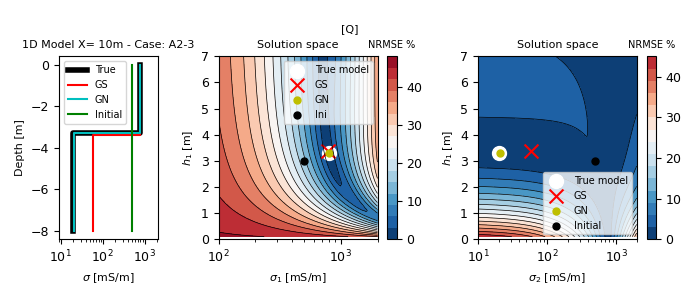

In [13]:
fig, ax = plt.subplots(1,3, figsize=(7,3), gridspec_kw={'width_ratios': [1, 2, 2]})

PlotErrorSpace2(ax[0], ax[1], model_A2_3[pos], model_GS_A2_3[pos], model_GI_A2_3[pos], model_ini, model_GI_A2_3_hist, err_A2_3_s2, models_err_A2_3_s2, 100, 2000, 0, 7, 
               case='A2-3', method='Solution space', colorbar=True)
PlotErrorSpace1(ax[2], model_A2_3[pos], model_GS_A2_3[pos], model_GI_A2_3[pos], model_ini, model_GI_A2_3_hist, err_A2_3_s1, models_err_A2_3_s1, 
               10, 2000, 0,7, 
               case='A2-3', method='Solution space', colorbar=True)
fig.suptitle('[Q]', x=0.5, y=0.92, fontsize=8)
plt.tight_layout()